In [55]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")
data_dir = "../"

# Resource Utilisation

Resource utilisation was measured during the creation and termination of deployments. This notebook displays the average total deployment and termination times depending on different resource combinations. Additionally, the cpu and memory utilisation during the deployment and termination processes is visualized. Each configuration has been tested three times (except all)  each for different amounts of concurrent deployments:
- Single OpenFaaS (resource 1, function 1) with concurrent deployments: 1, 2, 4,6, 8  
- Single Lambda (resources 14, 15, function 1) with concurrent deployments: 1, 2, 4, 6
- Single K8S (resource 6, service 1) with concurrent deployments: 1, 2, 4, 6
- Single EC2 (resource 12, function 1) with concurrent deployments: 1, 2, 4
- Multiple OpenFaaS (resources 1, 2, 3, function 1) with concurrent deployments: 1, 2, 4, 6
- Multiple K8S (resource 6, service 1, 2, 3) with concurrent deployments: 1, 2, 4, 6
- Multi Multiple  OpenFaaS (resources 1, 2, 3, function 1, 2, 3 on all resources) with concurrent deployments: 1, 2, 4, 6
- All (resources 1, 2, 3, 6, 12,  14, 15, function 1, service 1) with concurrent deployments: 1, 2, 4

The original data can be found in [reaction_time](../utilisation)

In [56]:
ru_dir = os.path.join(data_dir, "utilisation")

In [57]:
df_timestamps = pd.DataFrame()
df_util = pd.DataFrame()

for root, dirs, files in os.walk(ru_dir):
       for subdir in dirs:
              curr_ru_dir = os.path.join(root, subdir)               
              start_timestamp = 0
              finish_timestamp = 2_000_000_000_000
              for file_path in glob.glob(curr_ru_dir + "/*.csv"):
                     df = pd.read_csv(file_path)
                     df["type"] = subdir
                     concurrent_deployments = file_path.split(curr_ru_dir)[1].split('_')[3].split('.')[0]
                     df['concurrent_deployments'] = int(concurrent_deployments)
                     
                     if file_path.endswith('_util.csv'):
                            df = df.drop('id', axis=1)
                            df = df.drop(df[df["timestamp"] > (finish_timestamp + 30000)].index)
                            df["timestamp"] = (df["timestamp"] - start_timestamp) / 1000 
                            df["memory"] = df["memory"] / 1_000_000_000
                            df_util = pd.concat([df_util, df.drop_duplicates(subset=['timestamp', 'cpu', 'memory'])], ignore_index=True)
                     else:
                            df["start_response_time"] = df["start_response"] - df["start"]
                            df["terminate_response_time"] = df["terminate_response"] - df["terminate"]
                            start_timestamp = df["start"].min()
                            finish_timestamp = df["terminated"].max()
                            df["start"] = (df["start"] - start_timestamp) / 1000
                            df["deployed"] = (df["deployed"] - start_timestamp) / 1000
                            df["terminate"] = (df["terminate"] - start_timestamp) / 1000
                            df["terminated"] = (df["terminated"] - start_timestamp) / 1000
                            df["deployment_time"] = df["deployed"] - df["start"]
                            df["termination_time"] = df["terminated"] - df["terminate"]
                            df_timestamps = pd.concat([df_timestamps, df], ignore_index=True)

In [58]:
df_timestamps

,id,request_idx,deployment_id,start,start_response,deployed,terminate,terminate_response,terminated,function_deployments,service_deployments,type,concurrent_deployments,start_response_time,terminate_response_time,deployment_time,termination_time
0,0,0,1737,0.000,1711576065012,182.818,188.508,1711576253220,255.015,6,1,all,1,515,215,182.818,66.507
1,1,0,1738,256.616,1711576321623,437.829,444.711,1711576509417,511.135,6,1,all,1,510,209,181.213,66.424
2,2,0,1739,512.913,1711576577925,704.421,711.412,1711576776319,781.109,6,1,all,1,515,410,191.508,69.697
3,0,0,1741,0.000,1711577413111,195.214,204.948,1711577617512,274.322,6,1,all,2,1153,606,195.214,69.374
4,0,1,1740,0.068,1711577413159,192.390,204.998,1711577618719,284.018,6,1,all,2,1133,1763,192.322,79.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2,3,1443,84.501,1711533829660,103.956,116.100,1711533860108,119.949,1,0,single_openfaas,8,2212,1061,19.455,3.849
296,2,4,1442,84.545,1711533829506,101.398,116.145,1711533860608,119.949,1,0,single_openfaas,8,2014,1516,16.853,3.804
297,2,5,1447,84.590,1711533831807,101.255,116.199,1711533861014,120.265,1,0,single_openfaas,8,4270,1868,16.665,4.066
298,2,6,1449,84.635,1711533831611,108.531,116.244,1711533861816,120.584,1,0,single_openfaas,8,4029,2625,23.896,4.340


In [59]:
df_util

,timestamp,cpu,memory,type,concurrent_deployments
0,-13.497,0.294229,2.634293,all,1
1,5.503,0.596050,2.655822,all,1
2,25.503,0.774762,2.670342,all,1
3,44.503,1.420955,3.256762,all,1
4,57.503,0.822389,3.443806,all,1
...,...,...,...,...,...
626,72.053,1.704708,2.681688,single_openfaas,8
627,90.053,0.923496,2.644722,single_openfaas,8
628,109.053,1.777618,2.681827,single_openfaas,8
629,126.053,0.893693,2.531701,single_openfaas,8


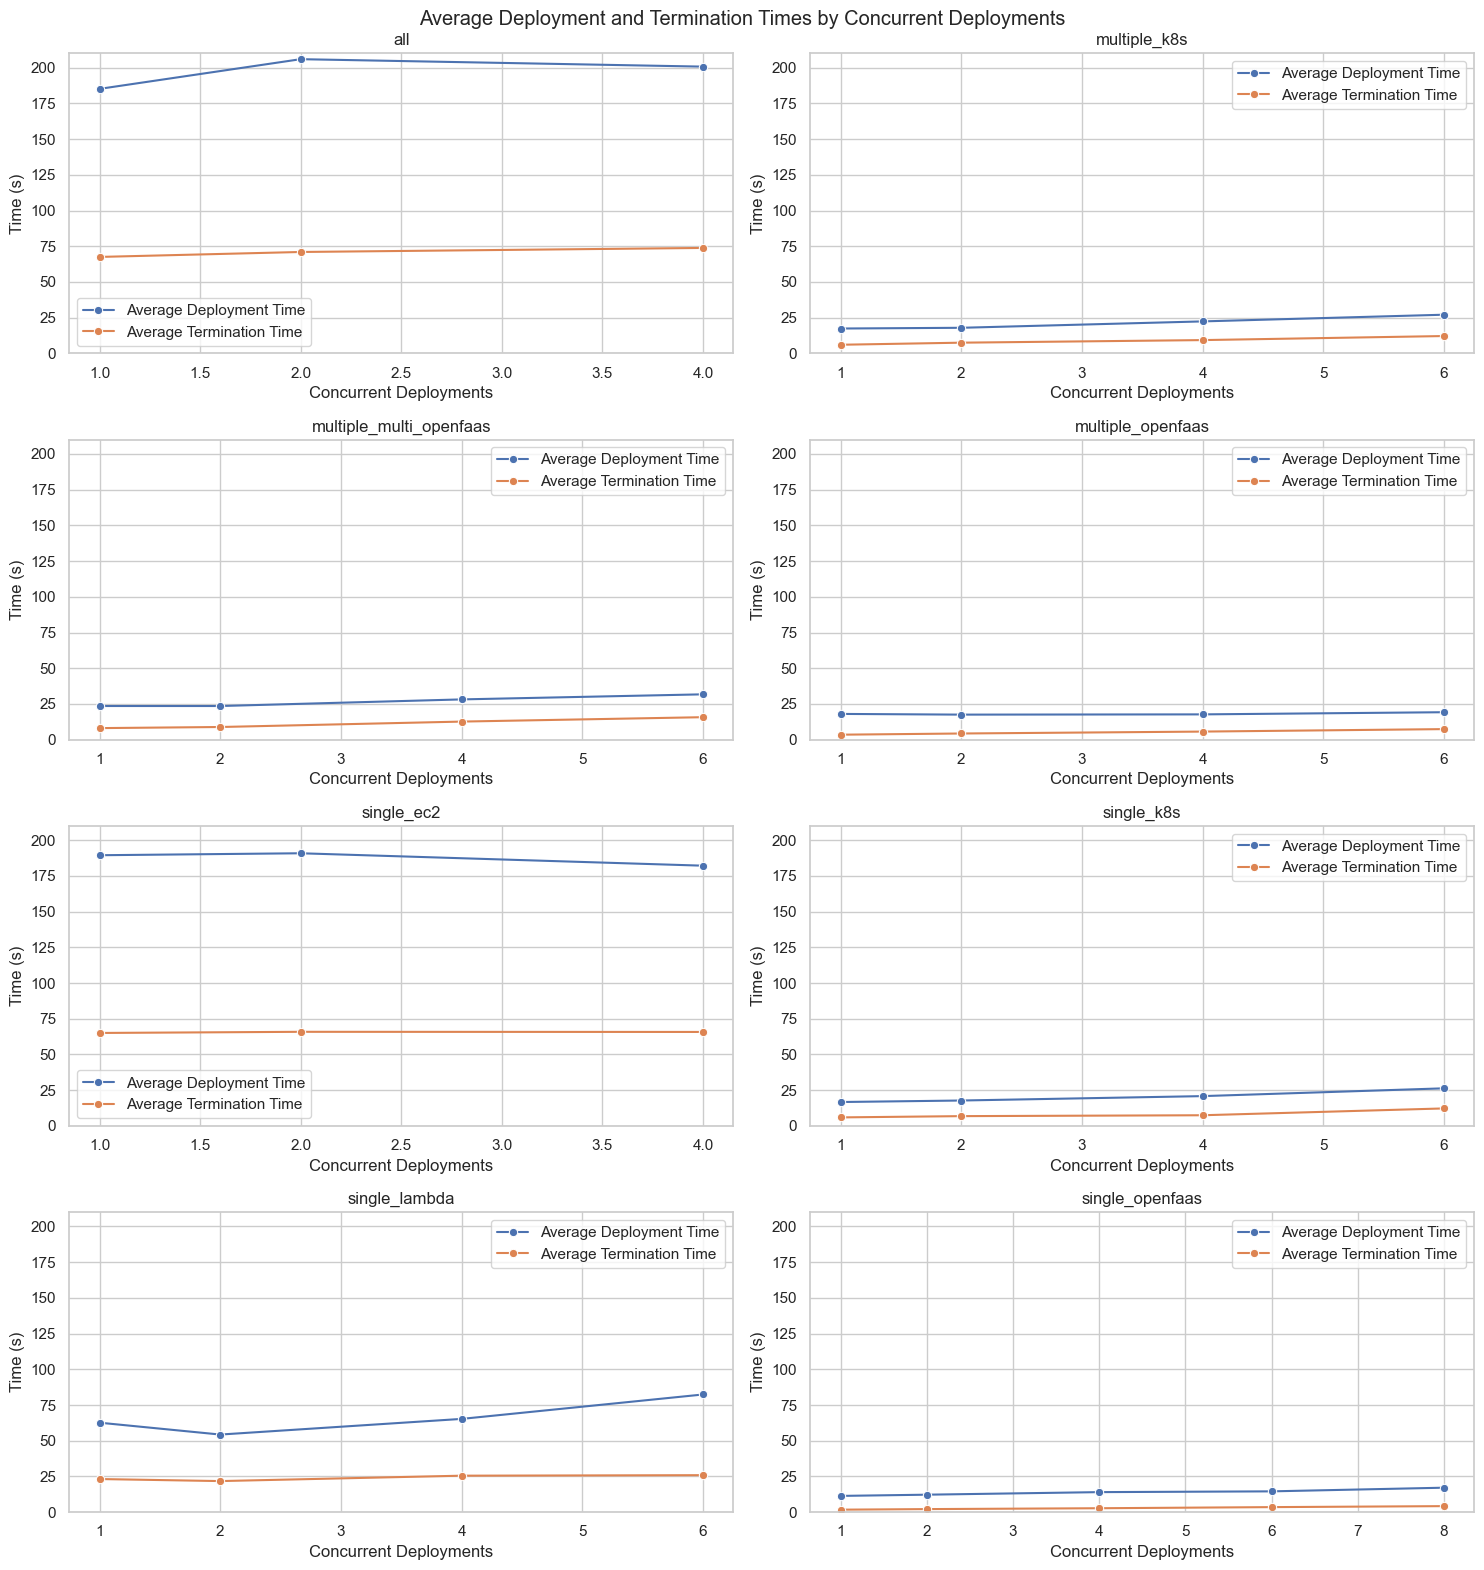

In [60]:
grouped_timestamps = df_timestamps.groupby(['type', 'concurrent_deployments']).mean().reset_index()

types = grouped_timestamps['type'].unique()

num_rows = (len(types) + 1) // 2
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 4*num_rows))
axs = axs.flatten()
y_min = 0
y_max = 210
for i, type_ in enumerate(types):
       subset_df = grouped_timestamps[grouped_timestamps['type'] == type_]
       sns.lineplot(data=subset_df, x='concurrent_deployments', y='deployment_time', ax=axs[i], label='Average Deployment Time', marker='o')
       sns.lineplot(data=subset_df, x='concurrent_deployments', y='termination_time', ax=axs[i], label='Average Termination Time', marker='o')
       axs[i].set_ylim(y_min, y_max)
       axs[i].set_xlabel('Concurrent Deployments')
       axs[i].set_ylabel('Time (s)')
       axs[i].set_title(f'{type_}')
for ax in axs[len(types):]:
       ax.axis('off')
plt.suptitle('Average Deployment and Termination Times by Concurrent Deployments')
plt.tight_layout()
plt.show()

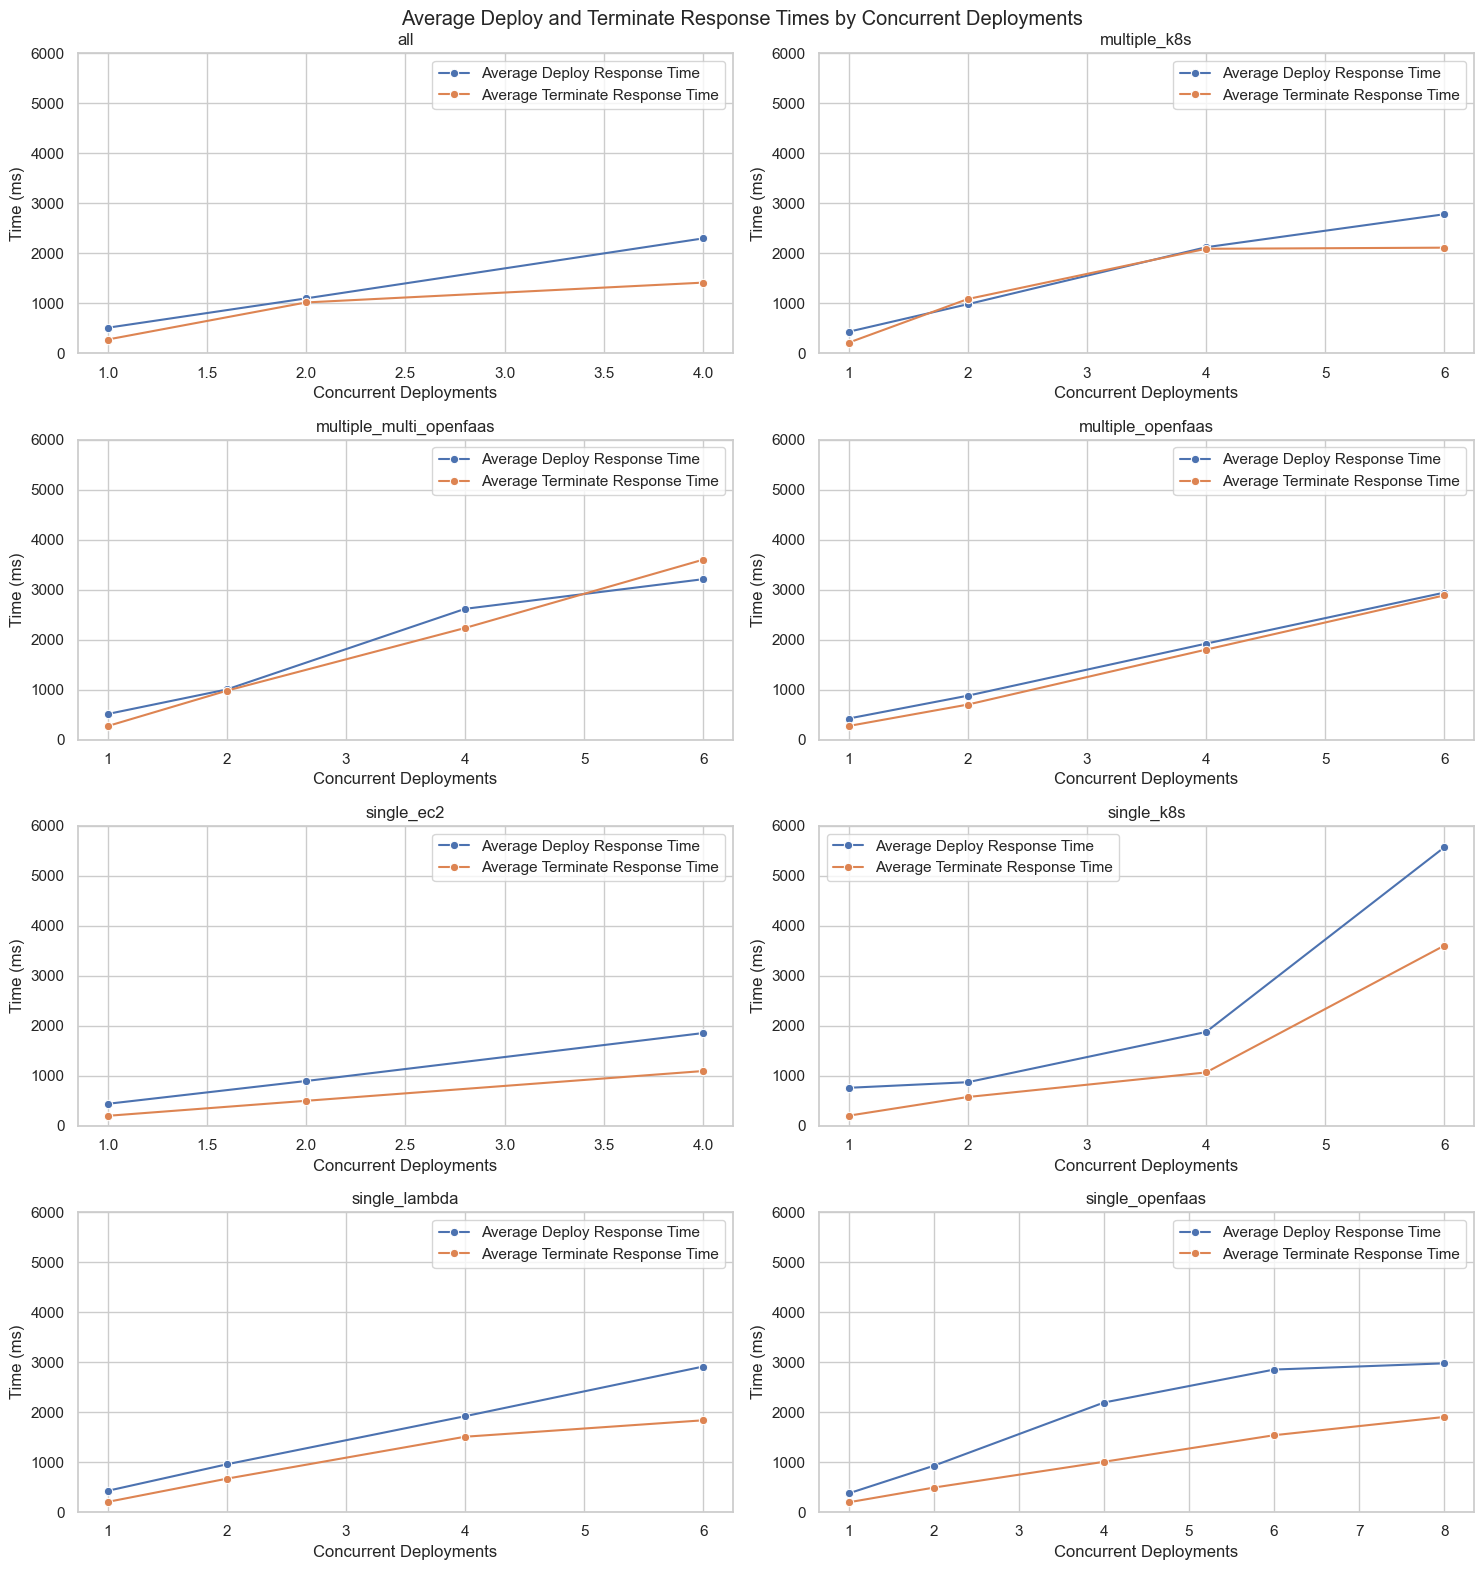

In [61]:
grouped_timestamps = df_timestamps.groupby(['type', 'concurrent_deployments']).mean().reset_index()

types = grouped_timestamps['type'].unique()

num_rows = (len(types) + 1) // 2
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 4*num_rows))
axs = axs.flatten()
y_min = 0
y_max = 6_000
for i, type_ in enumerate(types):
       subset_df = grouped_timestamps[grouped_timestamps['type'] == type_]
       sns.lineplot(data=subset_df, x='concurrent_deployments', y='start_response_time', ax=axs[i], label='Average Deploy Response Time', marker='o')
       sns.lineplot(data=subset_df, x='concurrent_deployments', y='terminate_response_time', ax=axs[i], label='Average Terminate Response Time', marker='o')
       axs[i].set_ylim(y_min, y_max)
       axs[i].set_xlabel('Concurrent Deployments')
       axs[i].set_ylabel('Time (ms)')
       axs[i].set_title(f'{type_}')
for ax in axs[len(types):]:
       ax.axis('off')
plt.suptitle('Average Deploy and Terminate Response Times by Concurrent Deployments')
plt.tight_layout()
plt.show()

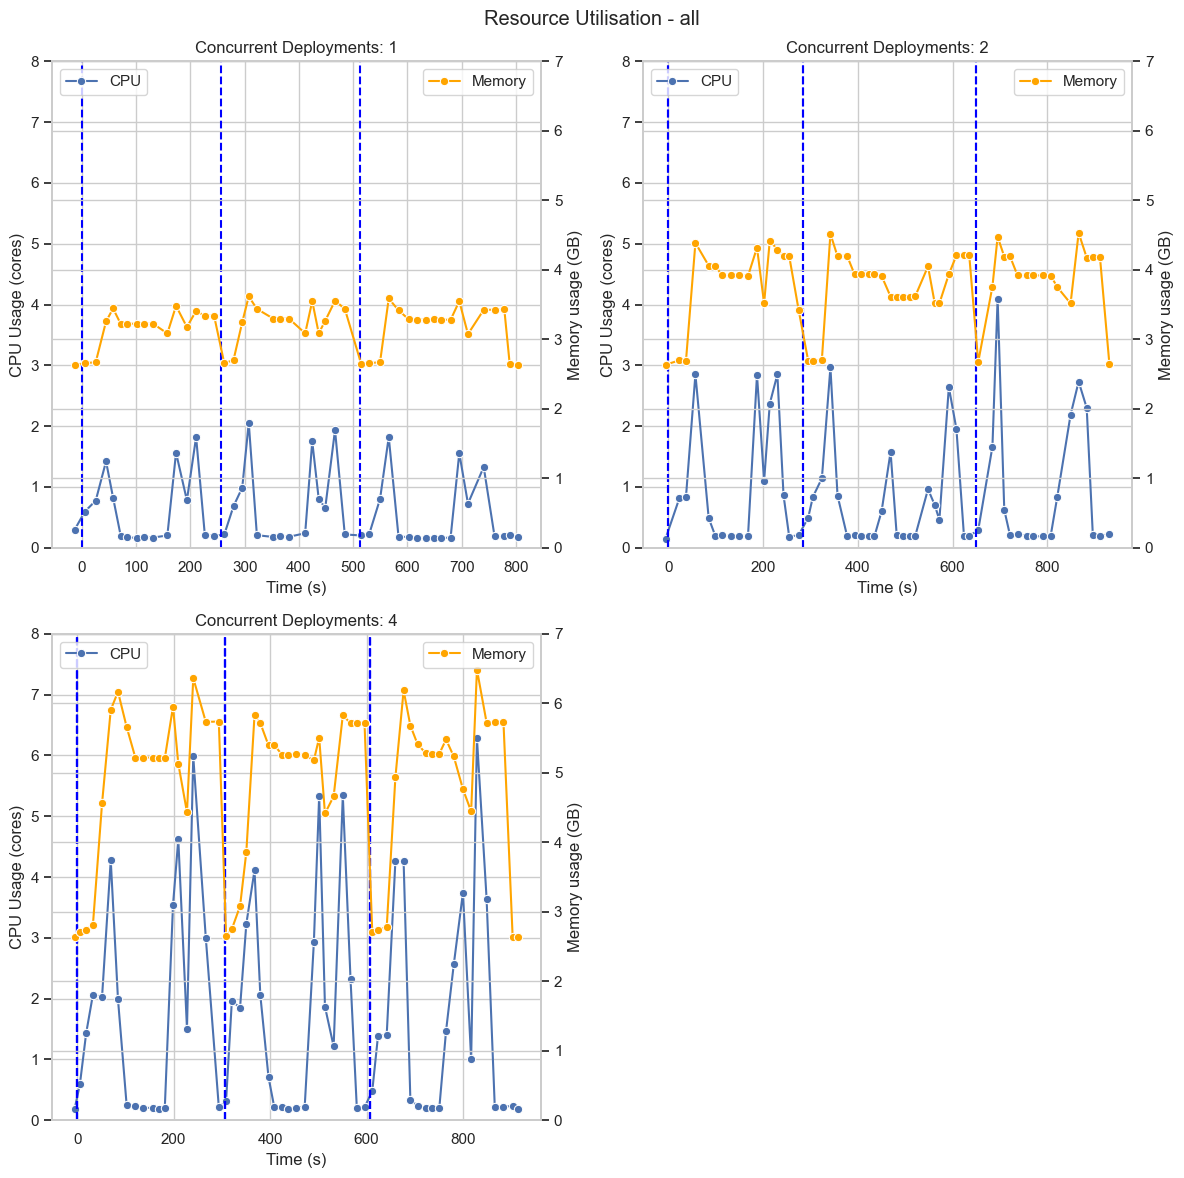

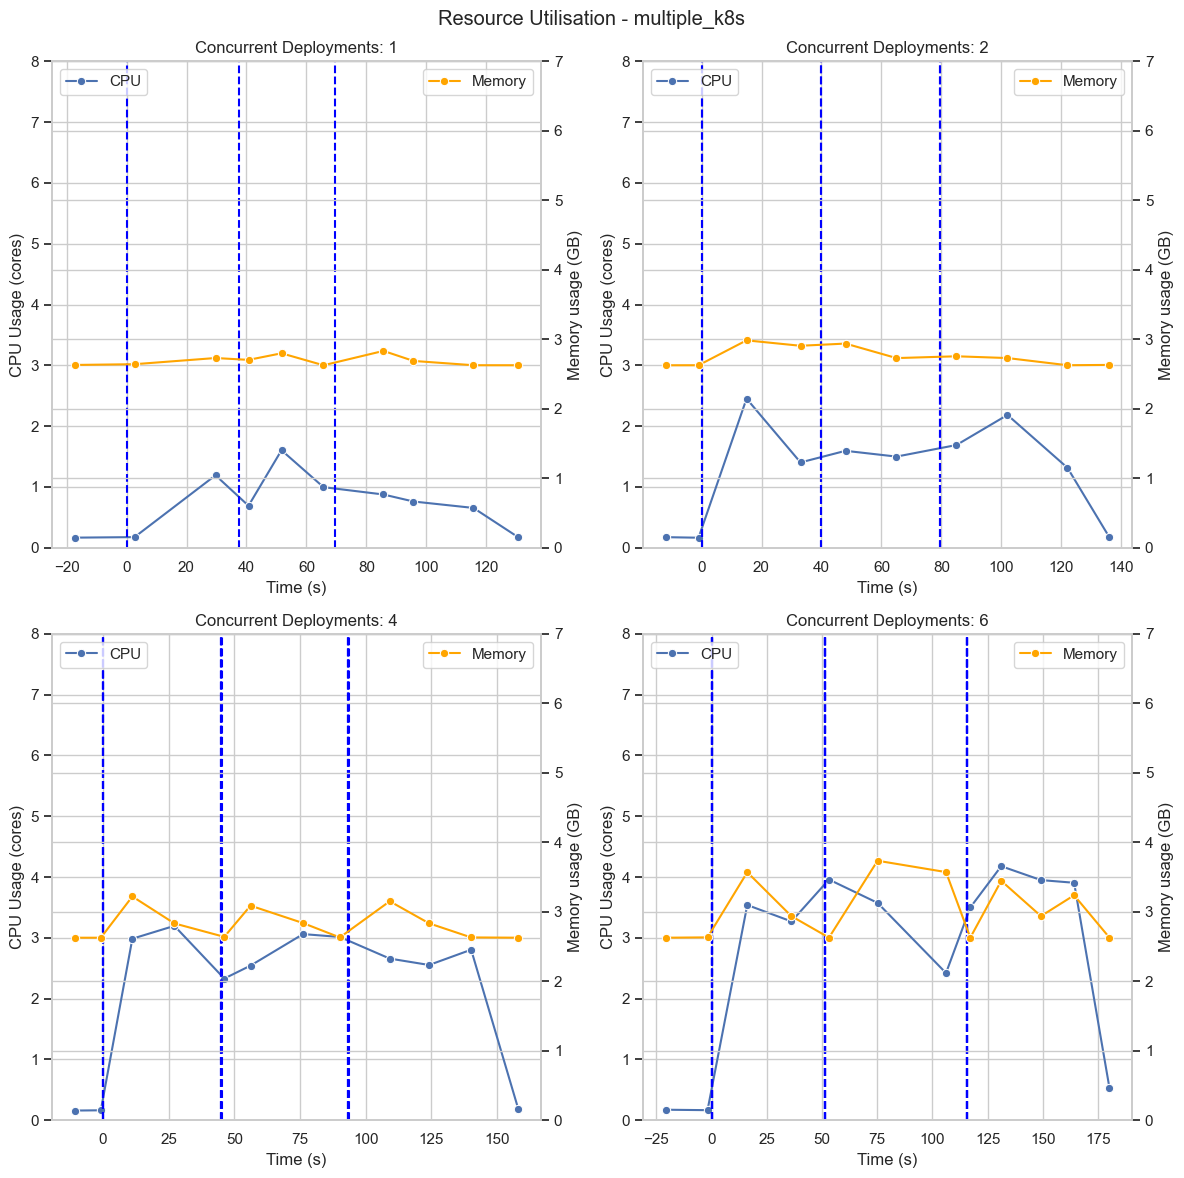

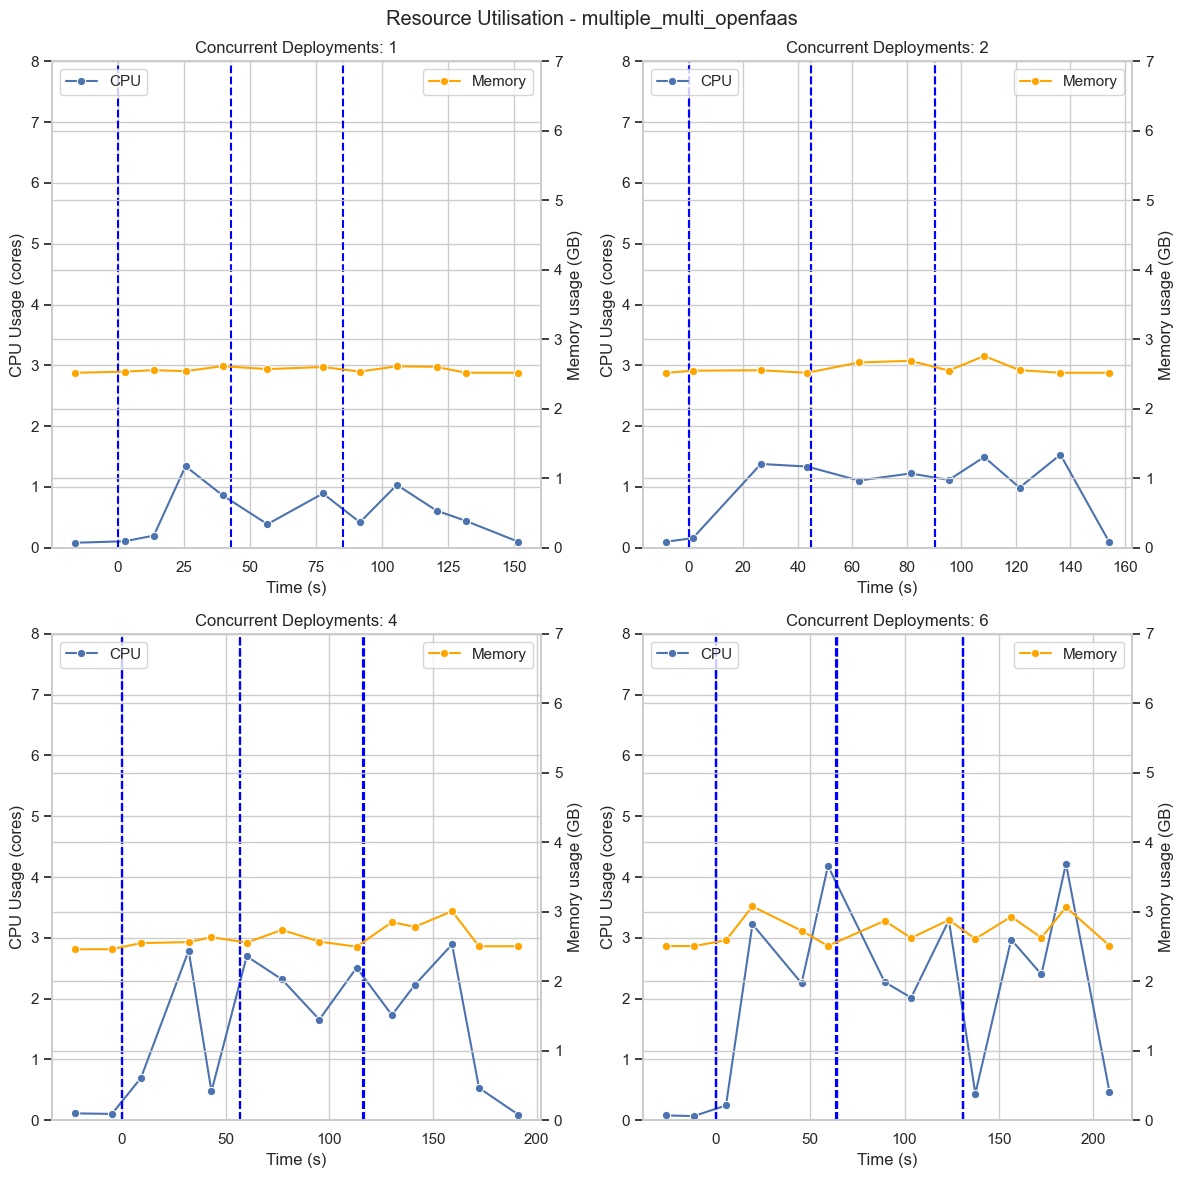

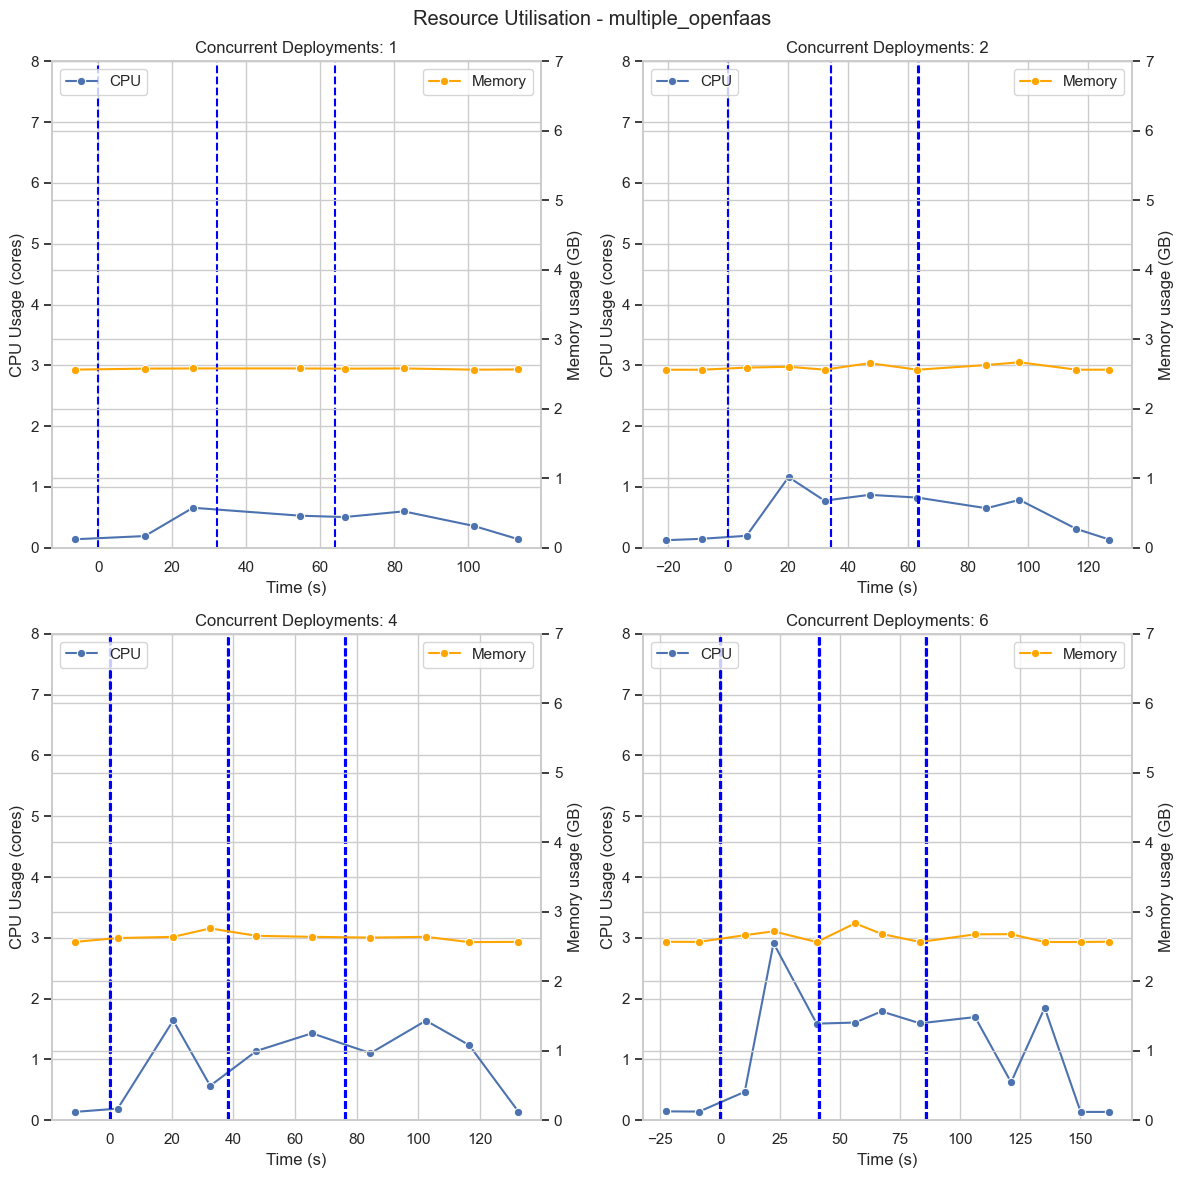

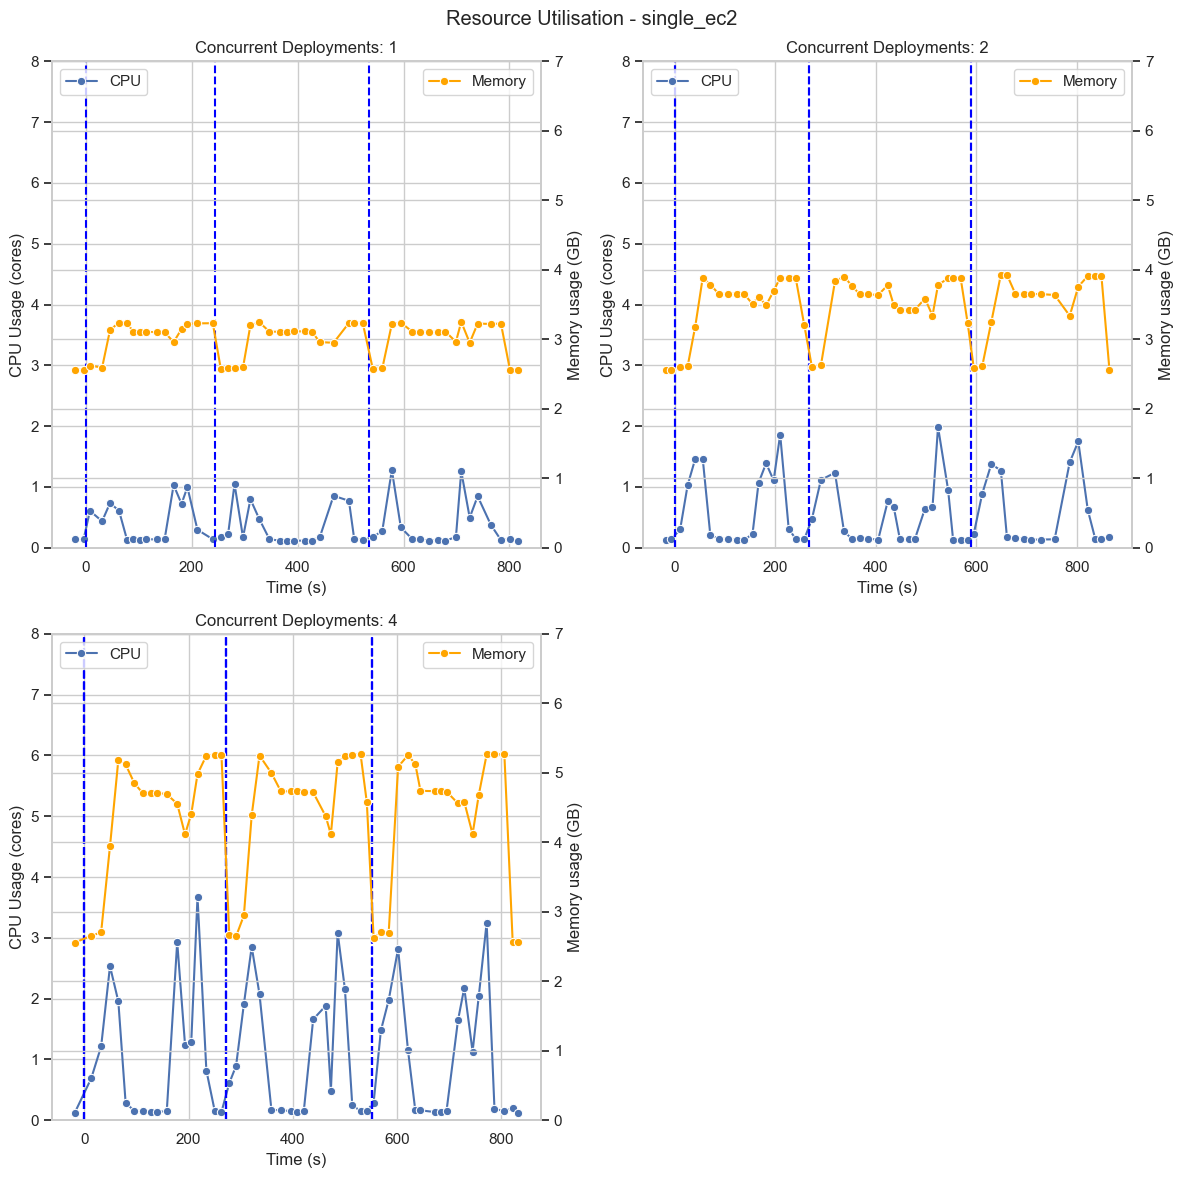

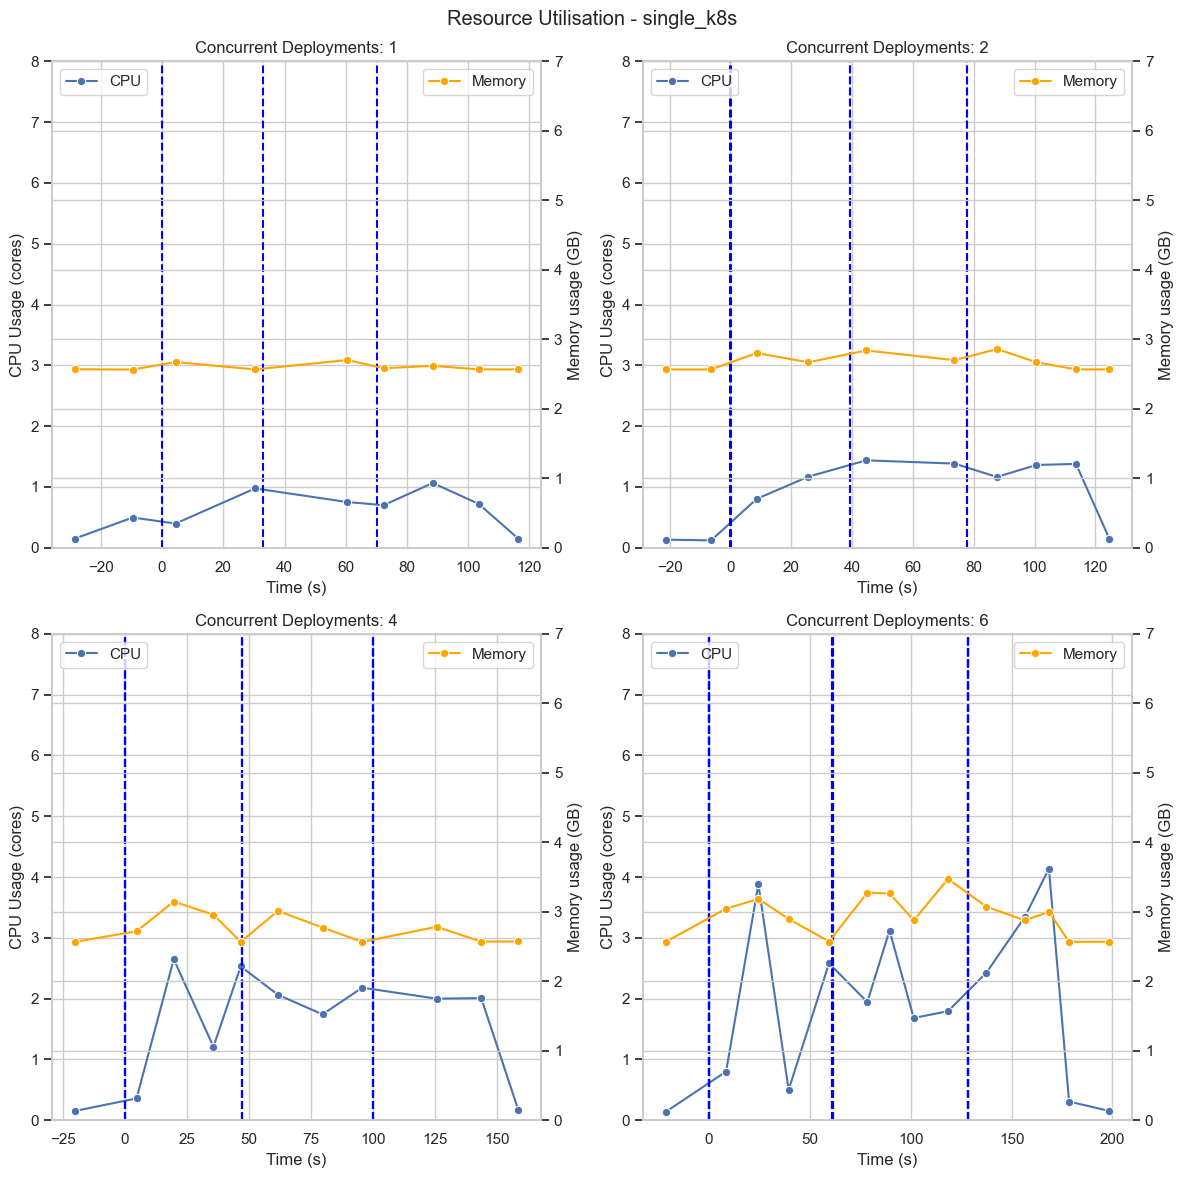

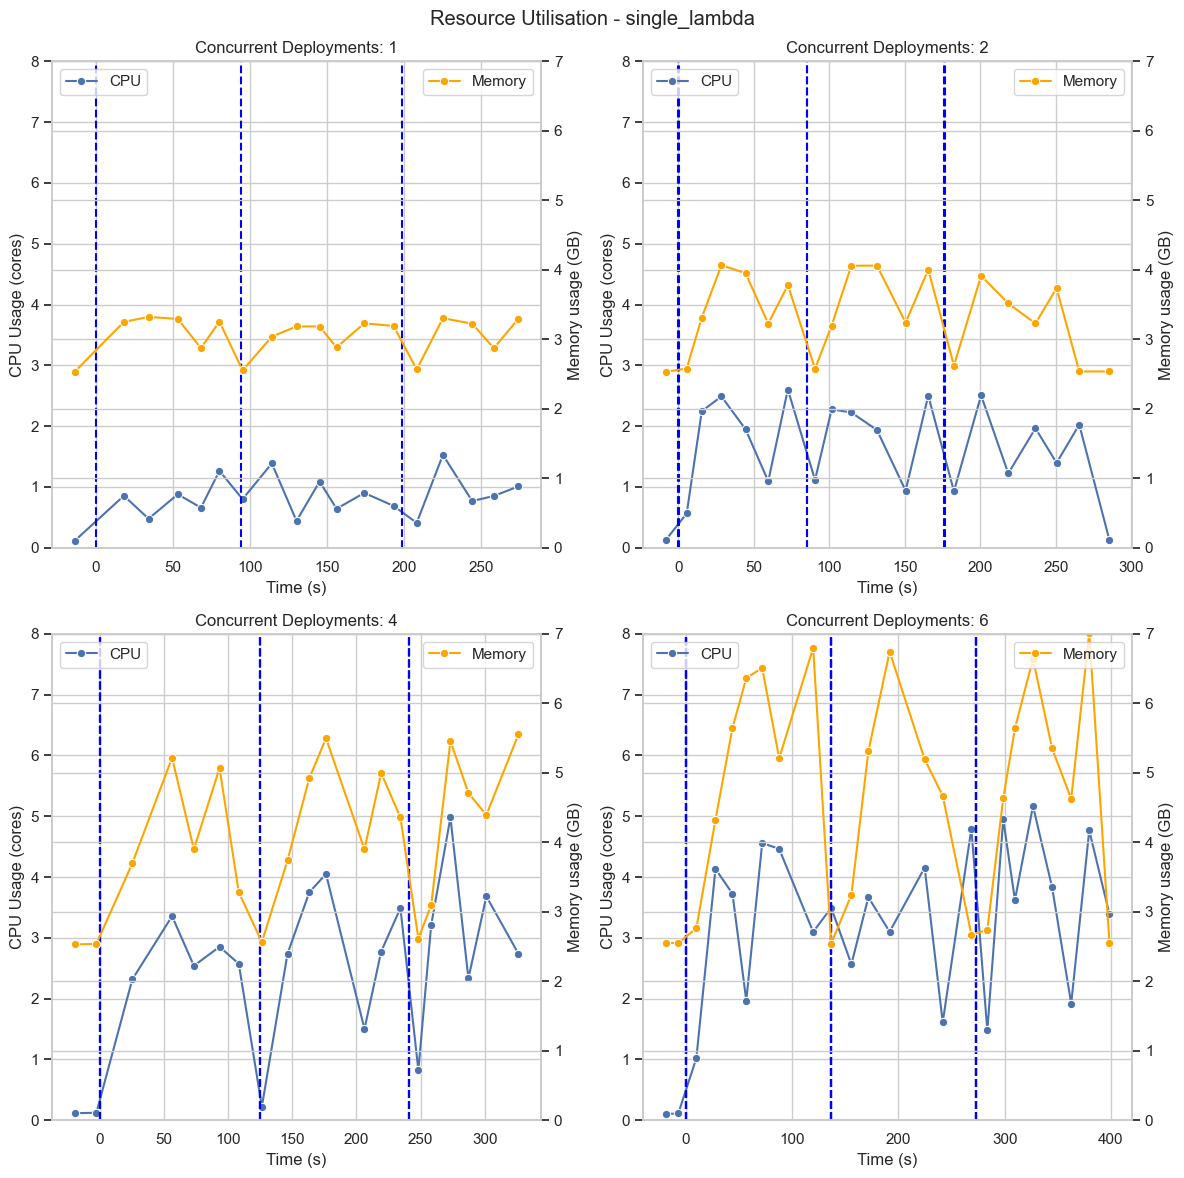

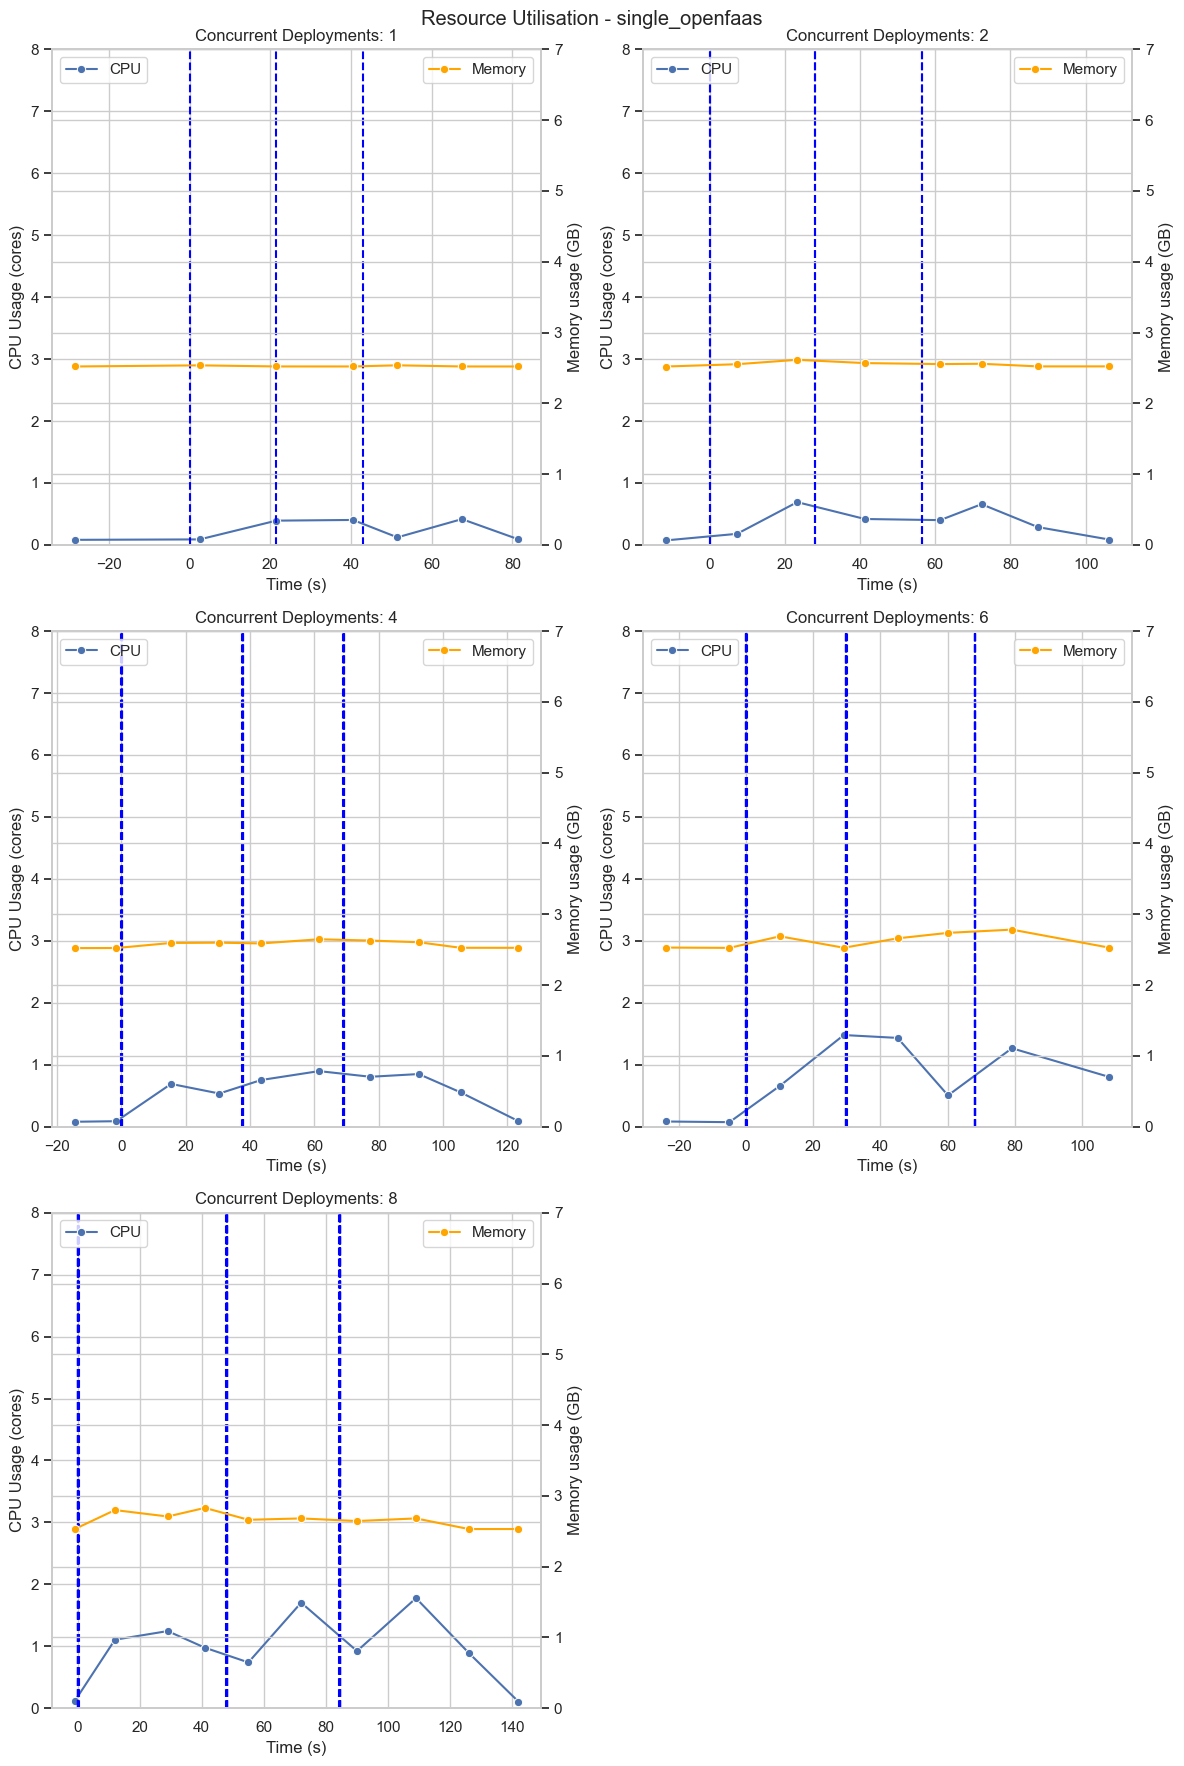

In [62]:
types = df_util['type'].unique()
df_util['timestamp'] = df_util['timestamp']

cpu_min = 0
cpu_max = 8
memory_min = 0
memory_max = 7
for type_ in types:
       type_df = df_util[df_util['type'] == type_]
       concurrent_deployments = type_df['concurrent_deployments'].unique()
       num_subplots = len(concurrent_deployments)
       num_rows = (num_subplots + 1) // 2

       # Check if there is only one subplot needed
       if num_subplots == 1:
              fig, ax = plt.subplots(figsize=(6, 6))
              ax = [ax]
       else:
              fig, axs = plt.subplots(num_rows, 2, figsize=(12, 6*num_rows))
              if isinstance(axs, np.ndarray):
                     ax = axs.ravel().tolist()
                     if num_subplots % 2 != 0:
                            fig.delaxes(ax[-1])

       for i, concurrent_deployment in enumerate(concurrent_deployments):
              concurrent_df = type_df[type_df['concurrent_deployments'] == concurrent_deployment]
              ax[i].set_ylim(cpu_min, cpu_max)
              sns.lineplot(data=concurrent_df, x='timestamp', y='cpu', ax=ax[i], label=f'CPU', marker='o')

              ax_mem = ax[i].twinx()
              sns.lineplot(data=concurrent_df, x='timestamp', y='memory', ax=ax_mem, color='orange', label=f'Memory', marker='o')

              ax_mem.set_ylim(memory_min, memory_max)
              ax_mem.set_ylabel('Memory usage (GB)')
              ax_mem.legend(loc='upper right')   
              ax[i].set_ylabel('CPU Usage (cores)')
              ax[i].set_xlabel('Time (s)')
              ax[i].set_title(f'Concurrent Deployments: {concurrent_deployment}')
              ax[i].legend(loc='upper left')
              
              start_times = df_timestamps[(df_timestamps['type'] == type_) & (df_timestamps['concurrent_deployments'] == concurrent_deployment)]['start']
              for start_time in start_times:
                     ax[i].axvline(x=start_time, color='blue', linestyle='--', label='Deployment Start')

       plt.suptitle(f'Resource Utilisation - {type_}')
       plt.tight_layout()
       plt.show()